In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt #to plot some parameters in seaborn
from scipy.stats import ttest_ind, f_oneway, anderson_ksamp, ks_2samp, linregress
from utils.fairness_functions import *

In [2]:
biased_model = True

In [3]:
if biased_model == True:
    path="./data/model_output_biased.csv"
else:
    path="./data/model_output_unbiased.csv"
    
df = pd.read_csv(path)
df.head()

,Sex,Prob_default,Predicted_default,Realised_default
0,male,0.070398,0,0
1,female,0.680953,1,1
2,male,0.066914,0,0
3,male,0.612084,1,0
4,male,0.470040,1,1


# Central tendency comparison: T-test & F-test

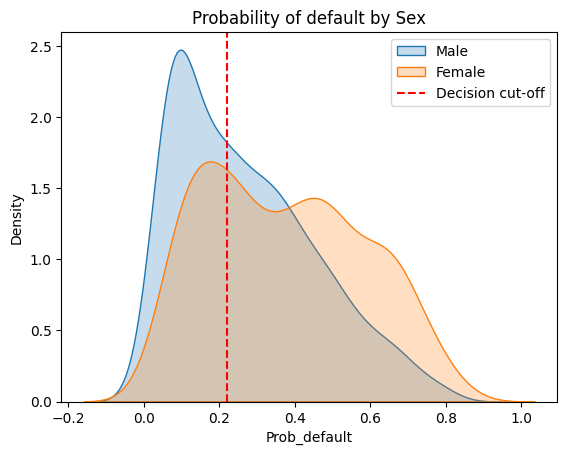

In [4]:
# plot the density plot
sns.kdeplot(df.loc[df['Sex']=='male', 'Prob_default'], shade=True, label='Male')
sns.kdeplot(df.loc[df['Sex']=='female', 'Prob_default'], shade=True, label='Female')

# add red dotted line at 0.21930892990126283
plt.axvline(x=0.21930892990126283, color='r', linestyle='--', label='Decision cut-off')

# add legend and title
plt.legend()
plt.title('Probability of default by Sex')

# display the plot
plt.show()


In [5]:
# separate the male and female groups
male = df[df['Sex'] == 'male']['Prob_default'].sort_values()
female = df[df['Sex'] == 'female']['Prob_default'].sort_values()

In [6]:
# perform t-test
t_stat, p_value = ttest_ind(male, female)
ttest_results = pd.DataFrame({'Statistic': t_stat, 'P-value': p_value}, index=['T-test'])

# perform f-test (one-way ANOVA)
f_stat, p_value = f_oneway(male, female)
anova_results = pd.DataFrame({'Statistic': f_stat, 'P-value': p_value}, index=['F-test'])

# combine the results into a single table
results_table = pd.concat([ttest_results, anova_results])

In [7]:
results_table

,Statistic,P-value
T-test,-7.912376,6.680160e-15
F-test,62.605688,6.680160e-15


# Distance between distributions

In [8]:
mean1 = np.mean(male)
mean2 = np.mean(female)
std1 = np.std(male, ddof=1)  # use ddof=1 for sample standard deviation
std2 = np.std(female, ddof=1)

# calculate Cohen's d
d = (mean2 - mean1) / np.sqrt((std1 ** 2 + std2 ** 2) / 2)

print("Cohen's d:", d)

Cohen's d: 0.5290337806154063


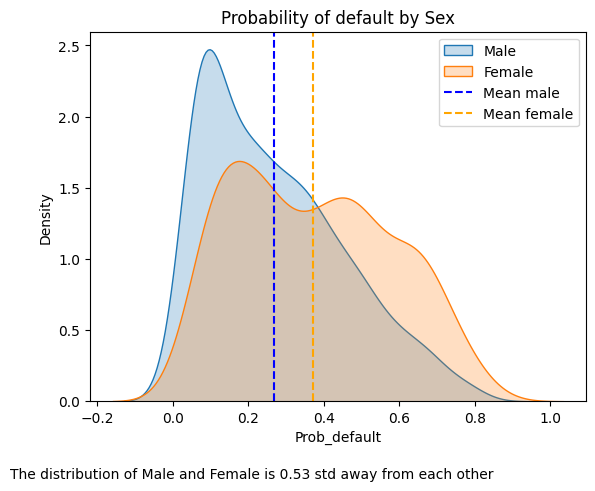

In [9]:
# plot the density plot

sns.kdeplot(df.loc[df['Sex']=='male', 'Prob_default'], shade=True, label='Male')
sns.kdeplot(df.loc[df['Sex']=='female', 'Prob_default'], shade=True, label='Female')

# add Cohen's d as a horizontal line
plt.axvline(x=mean1, label = "Mean male", color='blue', linestyle='--')
plt.axvline(x=mean2, label = "Mean female", color='orange', linestyle='--')

# add legend and title
plt.legend()
plt.title('Probability of default by Sex')
plt.figtext(0, -0.05, f'The distribution of Male and Female is {round(d, 2)} std away from each other')

# display the plot
plt.show()


# Cumulative distribution comparison

In [10]:
male, cdf_male = cdf(male) 
female, cdf_female = cdf(female)

# Perform KS test
ks_stat, ks_pvalue = ks_2samp(male, female)

# Perform Anderson-Darling test
ad_stat, ad_crit_vals, ad_sig_level = anderson_ksamp([male, female])
ad_pvalue = 1 - ad_sig_level

# Create DataFrame with test results
results = pd.DataFrame({
    'Test': ['KS test', 'Anderson-Darling test'],
    'Statistic': [ks_stat, ad_stat],
    'P-value': [ks_pvalue, ad_pvalue]
})

C:\Users\FI40WR\AppData\Local\Temp\ipykernel_6476\1990712384.py:8: UserWarning: p-value floored: true value smaller than 0.001
  ad_stat, ad_crit_vals, ad_sig_level = anderson_ksamp([male, female])


In [11]:
results

,Test,Statistic,P-value
0,KS test,0.225339,5.150594e-10
1,Anderson-Darling test,37.477909,9.990000e-01


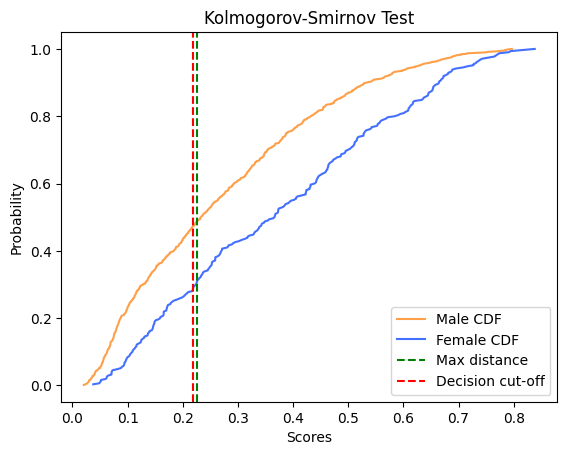

In [12]:
# Visualize CDF for each protected sub-sample
plt.plot(male, cdf_male, color = "#fea049", label="Male CDF")
plt.plot(female, cdf_female, color = "#4470ff", label="Female CDF")
plt.axvline(ks_stat, 0, 1, color="green", linestyle="dashed", label='Max distance')
plt.axvline(x=0.21930892990126283, color='r', linestyle='--', label='Decision cut-off')
plt.legend()
plt.title("Kolmogorov-Smirnov Test")
plt.xlabel("Scores")
plt.ylabel("Probability")
plt.show()

### Integral difference

In [13]:
np.trapz(y=cdf_male, x=male) - np.trapz(y=cdf_female, x=female)

0.061524422462421624

# Decile comparison in scores: PSI and Average Score Difference

In [14]:
df['Decile_rank'] = add_decile(df, 'Prob_default')
df['unique_key'] = range(0, len(df))
male_df =  df[df['Sex'] == 'male']
female_df =  df[df['Sex'] == 'female']

In [15]:
results_psi = PSI(male_df, female_df, 'Prob_default', 'unique_key')
results_psi

Prob_default_x                     unique_key_x    perc_x  \
                      mean       min       max        count             
Decile_rank                                                             
0                 0.050850  0.020553  0.070398           90  0.130435   
1                 0.086687  0.071584  0.105785           81  0.117391   
2                 0.127502  0.105911  0.150965           69  0.100000   
3                 0.182183  0.151137  0.210259           74  0.107246   
4                 0.235895  0.210292  0.263738           67  0.097101   
5                 0.300013  0.264348  0.332459           77  0.111594   
6                 0.367880  0.333942  0.403684           71  0.102899   
7                 0.443181  0.406951  0.486203           60  0.086957   
8                 0.537143  0.486348  0.604469           59  0.085507   
9                 0.683014  0.605468  0.796883           42  0.060870   

            Prob_default_y                     unique_key_y    perc_y  \
                      mean       min       max        count             
Decile_rank                                                             
0                 0.055919  0.037641  0.070627           10  0.032258   
1                 0.090520  0.070743  0.104911           19  0.061290   
2                 0.130830  0.106917  0.150927           31  0.100000   
3                 0.179171  0.156379  0.209798           26  0.083871   
4                 0.238227  0.217779  0.263401           33  0.106452   
5                 0.295712  0.266078  0.332634           23  0.074194   
6                 0.365518  0.335536  0.401759           29  0.093548   
7                 0.445904  0.405350  0.486202           40  0.129032   
8                 0.534391  0.486776  0.603899           41  0.132258   
9                 0.683148  0.608299  0.838234           58  0.187097   

                  PSI  
                       
Decile_rank            
0            0.137163  
1            0.036460  
2            0.000000  
3            0.005747  
4            0.000860  
5            0.015267  
6            0.000891  
7            0.016605  
8            0.020391  
9            0.141740

In [16]:
results_psi['PSI'].sum()

0.375122068619999

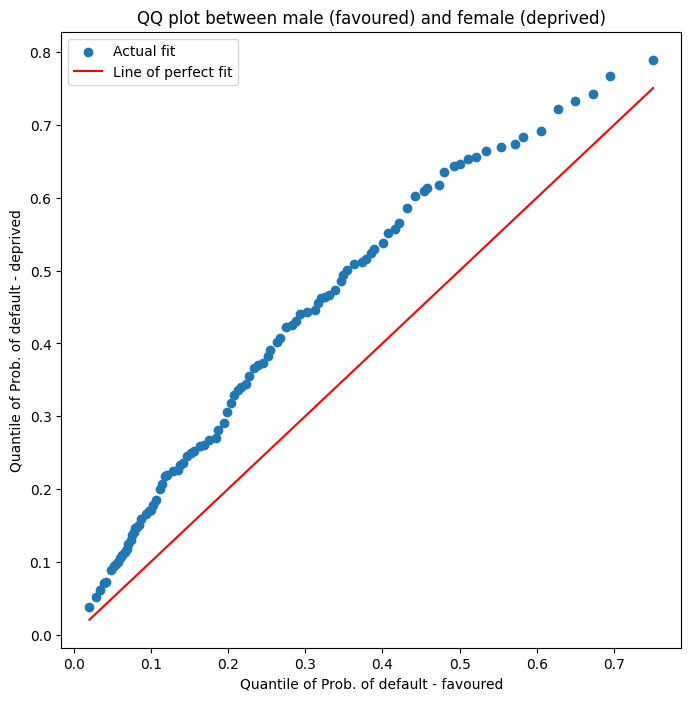

In [17]:
df_pct, linear_regression_result = score_percentile_comparison(
    df, 
    protected_variable = 'Sex', 
    score = 'Prob_default', 
    favoured_class='male', 
    deprived_class='female', 
    plot = True
)

In [18]:
df_pct

,q_deprived,q_favoured,difference
0,0.037641,0.020553,-0.017089
1,0.051439,0.029600,-0.021839
2,0.062006,0.034487,-0.027519
3,0.070659,0.039007,-0.031651
4,0.071926,0.042031,-0.029895
...,...,...,...
95,0.722127,0.627580,-0.094547
96,0.732652,0.649994,-0.082658
97,0.742025,0.672791,-0.069234
98,0.767408,0.694523,-0.072885


In [19]:
linear_regression_result

,slope,intercept,p_value
0,1.117082,0.072505,2.367781e-80


Interpretation: On average, the percentage difference in the percentile scores of the probability of default between the favoured and deprived group is 11.7%

In [20]:
# df_pct.to_excel("./data/pct_score_difference.xlsx", index=False)